In [12]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tqdm import tqdm
import numpy as np
from scipy.ndimage import zoom
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [13]:
###Get filepath
valid_filepaths = glob.glob('Valid_Images/*.jpg')

In [14]:
###GEt Tensor
import numpy as np
def path_to_tensor(img_path):
    print(img_path)
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)  

def get_tensors():
    eval_tensors = paths_to_tensor(valid_filepaths).astype('float32')/255
    return eval_tensors

eval_tensors = get_tensors()

  0%|                                                     | 0/4 [00:00<?, ?it/s]

Valid_Images/5473083156_a732543f82_z.jpg
Valid_Images/11527259755_0580281cda_z.jpg
Valid_Images/william-zhang-1058394-unsplash.jpg


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.03it/s]

Valid_Images/25529782781_b0abb74c1b_z.jpg


In [15]:
###Get Model
def get_model():
    input_layer = Input(shape = (224,224,3))
    x = Conv2D(32, (3, 3), padding='same', input_shape=(224,224,3), activation = 'relu')(input_layer)
    x = Conv2D(32, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), padding='same', activation = 'relu')(x)
    x = Conv2D(64, (3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3,3))(x)
    act_map = Activation('relu')(x)
    x = GlobalAveragePooling2D()(act_map)
    predictions = Dense(2, activation = 'softmax')(x)

    final_model = Model(inputs = input_layer, outputs = [predictions, act_map])
    final_model.compile(optimizer = 'adam', loss="categorical_crossentropy", metrics=["accuracy"])
    
    final_model.load_weights('weights.hdf5')
    
    return final_model

final_model = get_model()

In [16]:
###Get prediction and activation
def get_results():
    preds, activations = final_model.predict(eval_tensors)   
    return preds, activations

preds, activations = get_results()

In [26]:
tensor_to_show = 3
###Get weights and prepare activation map
def get_heatmap():
    act_map_tensor = activations[tensor_to_show].reshape(1, 52, 52, 128)
    weights_for_mult = np.array(final_model.layers[-1].get_weights()[0])
    final_output = np.dot(act_map_tensor, weights_for_mult)
    final_output2 = final_output[0, :, :, 1]
    out = zoom(final_output2, (4.31, 4.31), order=1, mode='reflect', prefilter =False)
    
    return out

out = get_heatmap()

In [27]:
#scaler = MinMaxScaler(feature_range = (0.5, .95))
scaler = StandardScaler()
new_out = scaler.fit_transform(out)

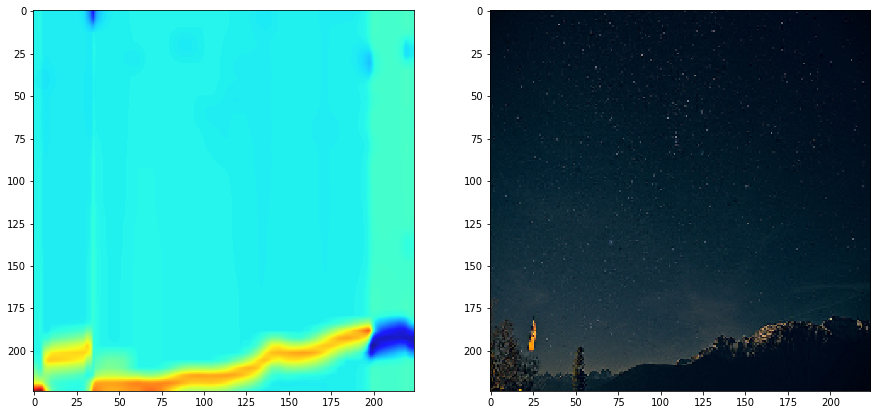

In [28]:
###Display Images
img = array_to_img(eval_tensors[tensor_to_show])
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,15))
ax1.imshow(new_out, cmap='jet', alpha=.9)
ax2.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
###Issues cost/run time